# Tech Only

## 1. Data Cleaning 

### 1.1 Filter by 2023 Winter Quarter

In [27]:
import pandas as pd
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv("Full_Data.csv")

# Convert date and time columns into datetime
df['Received Timestamp'] = pd.to_datetime(df['Received Date'] + ' ' + df['Received Time'])
df['Delivered Timestamp'] = pd.to_datetime(df['Delivered Date'] + ' ' + df['Delivered Time'])

# Drop original date and time columns if no longer needed
df = df.drop(columns=['Received Date', 'Received Time', 'Delivered Date', 'Delivered Time'])

# Ensure proper datatypes
df['# of Packages'] = pd.to_numeric(df['# of Packages'], errors='coerce').astype('Int64')
string_cols = ['Dataset Source', 'Carrier', 'Street Address', 'Recipient Name', 'Tracking Number']
df[string_cols] = df[string_cols].astype(str)

In [29]:
# Process Times
df['Process Time'] = df['Delivered Timestamp'] - df['Received Timestamp']

In [30]:
# Drop duplicates 
df= df.drop_duplicates()

In [31]:
# Filter for 2023 Winter quarter
start_date = pd.to_datetime("2023-09-01")
end_date = pd.to_datetime("2023-12-31")

df = df[
    (df['Received Timestamp'] >= start_date) &
    (df['Received Timestamp'] <= end_date)]

df = df[df['Dataset Source'] != 'RESSERV']

### 1.2 Looking into Process Time Distribution and Outliers

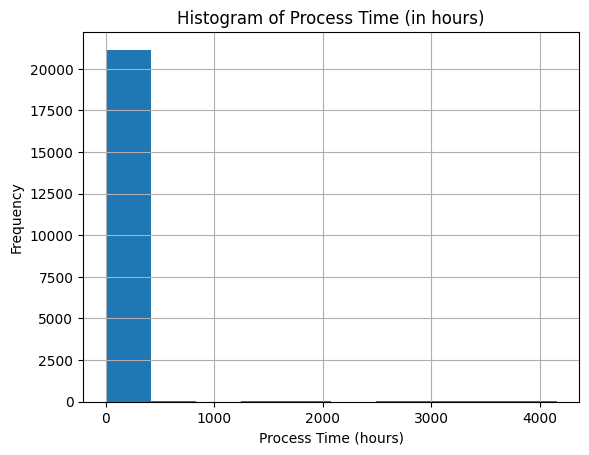

In [32]:
# Convert "Process Time" to timedelta
df["Process Time"] = pd.to_timedelta(df["Process Time"])

# Calculate statistics
mean_process_time = df["Process Time"].mean()
min_process_time = df["Process Time"].min()
max_process_time = df["Process Time"].max()

# Plot histogram (in hours for better readability)
df["Process Time (hours)"] = df["Process Time"].dt.total_seconds() / 3600

plt.hist(df["Process Time (hours)"], bins=10)
plt.title("Histogram of Process Time (in hours)")
plt.xlabel("Process Time (hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [33]:
# Log transformation 
df["Process Time (hours)"] = df["Process Time"].dt.total_seconds() / 3600
df["Log Process Time"] = np.log1p(df["Process Time (hours)"])  # log(1 + x) to handle 0s

### 1.3 Filter by locations

In [34]:
# Street address value counts
address_counts = df["Street Address"].value_counts().reset_index()
address_counts.columns = ["Street Address", "Count"]

In [35]:
# List of valid addresses
valid_addresses = [
    "2145 Sheridan Road", "2133 Sheridan Road", "2137 Tech Drive", "2190 Campus Drive", "2170 Campus Drive",
    "2233 Tech Drive", "2200 Campus Drive", "2205 Tech Drive", "2220 Campus Drive" 
]

# Remove USPS carriers from these addresses

In [36]:
# 1. Clean street addresses in the dataframe
df["Street Address Cleaned"] = df["Street Address"].str.upper().str.replace(
    r'\b(AVENUE|STREET|ROAD|DRIVE|CIRCLE|PLACE|LANE|COURT|TERRACE|BLVD|PARKWAY|WAY)\b', '', 
    regex=True
).str.strip()

# 2. Clean carrier field for easier matching
df["Carrier Cleaned"] = df["Carrier"].str.upper().str.strip()

# 3. Prepare valid address patterns (without suffixes)
def extract_main_part(address):
    address = address.upper()
    return re.sub(r'\b(AVENUE|STREET|ROAD|DRIVE|CIRCLE|PLACE|LANE|COURT|TERRACE|BLVD|PARKWAY|WAY)\b', '', address).strip()

main_name_patterns = [extract_main_part(addr) for addr in valid_addresses]
main_name_regex = "|".join(re.escape(name) for name in main_name_patterns)

# 4. Apply filtering
# Keep rows that match a valid address AND are not USPS
filtered_df = df[
    df["Street Address Cleaned"].str.contains(main_name_regex, na=False, regex=True) &
    (df["Carrier Cleaned"] != "USPS")
]

In [37]:
# Uncomment and run this only if you need the file again: 
# filtered_df.to_csv('filtered_df_tech.csv', index=False)

### 1.4 USPS vs Non USPS Distribution

In [38]:
# Assuming 'Carrier' column exists and needs cleaning
filtered_df["Carrier"] = filtered_df["Carrier"].str.upper().str.strip()

# Calculate USPS vs Non-USPS proportions
carrier_counts = filtered_df["Carrier Cleaned"].value_counts(normalize=True)

# Display the carrier distribution, uncomment the following two lines to view
# print("Carrier Distribution (Proportion):")
# print(carrier_counts)

# Optional: store proportions for weighting later
usps_proportion = carrier_counts.get('USPS', 0)
non_usps_proportion = 1 - usps_proportion

### 1.5 Data Exploration for Arrivals - Histogram

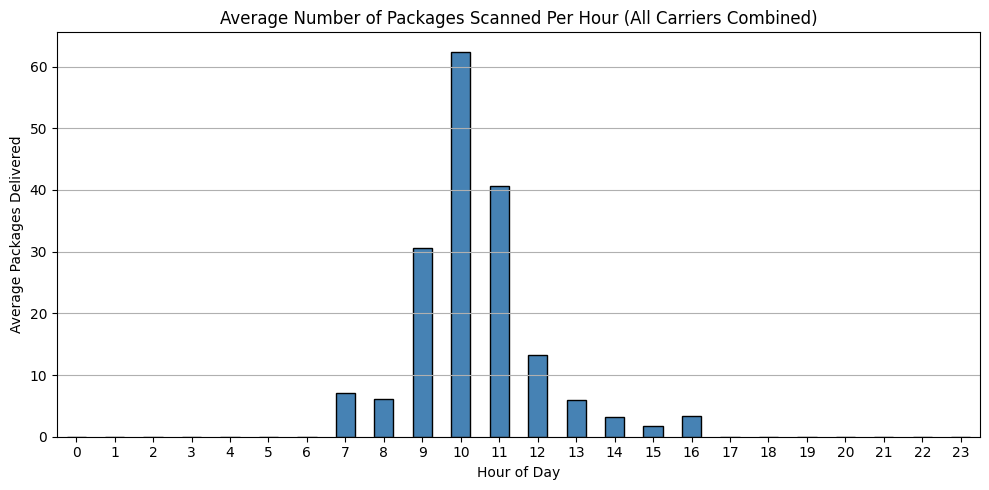

In [39]:
# Re-import necessary libraries after kernel reset
import pandas as pd
import matplotlib.pyplot as plt

# Extract hour and date
filtered_df["Hour"] = filtered_df["Received Timestamp"].dt.hour
filtered_df["Date"] = filtered_df["Received Timestamp"].dt.date

filtered_df = filtered_df[filtered_df["Received Timestamp"].dt.dayofweek < 5]

# Group total number of packages by Date and Hour (no carrier separation)
grouped_total = (
    filtered_df.groupby(["Date", "Hour"])
    .size()
    .reset_index(name="Package Count")
)

# Compute the average number of packages received per hour (across all days)
avg_per_hour_total = (
    grouped_total.groupby("Hour")["Package Count"]
    .mean()
    .reindex(range(24), fill_value=0)
)

# Plot the histogram
plt.figure(figsize=(10, 5))
avg_per_hour_total.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Average Number of Packages Scanned Per Hour (All Carriers Combined)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Packages Delivered")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

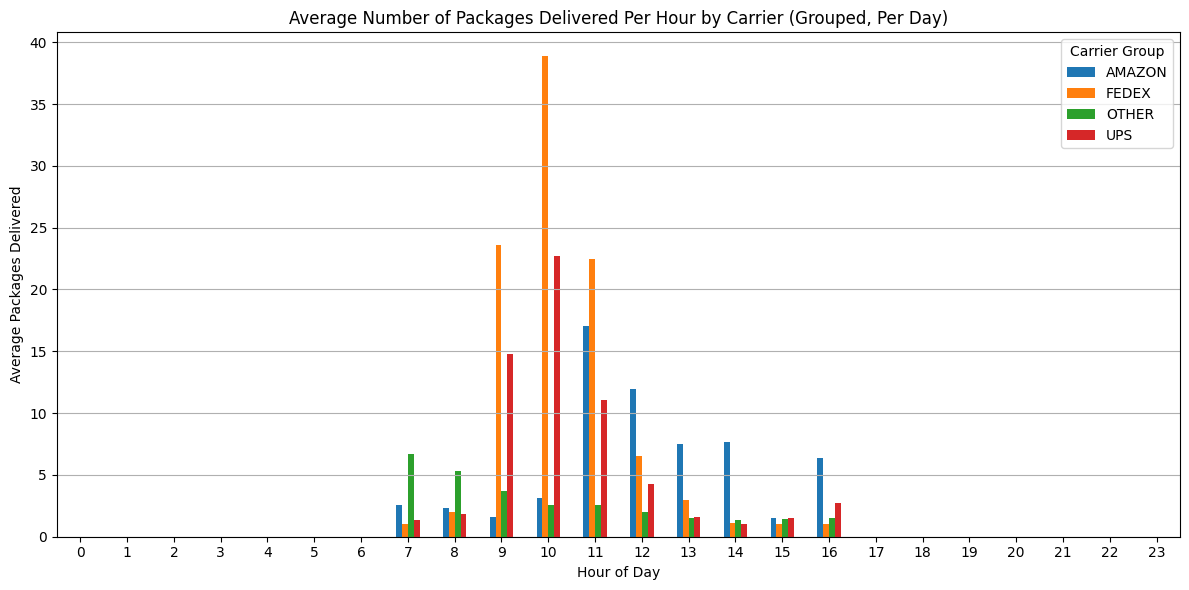

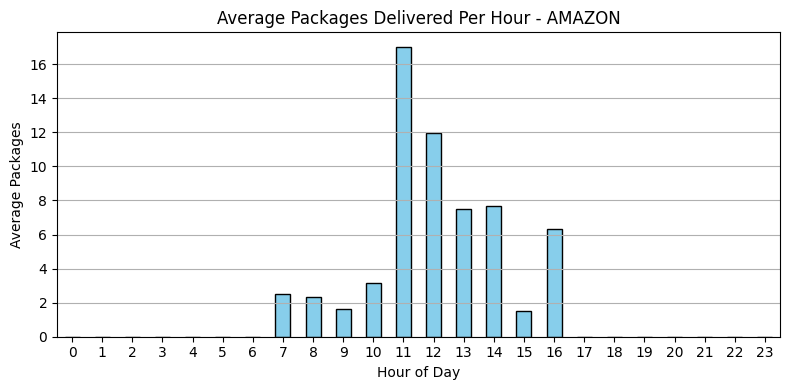

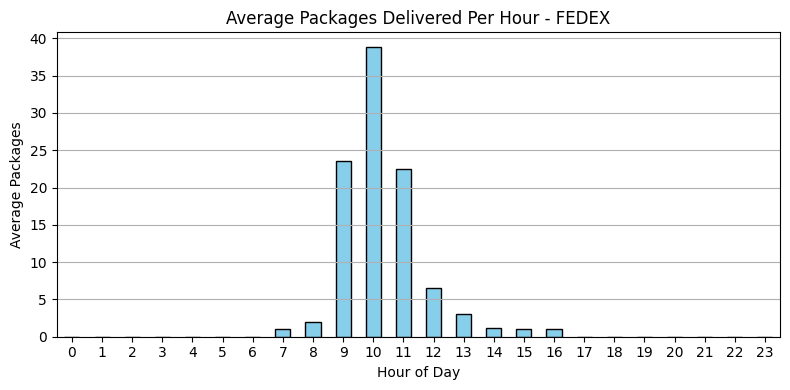

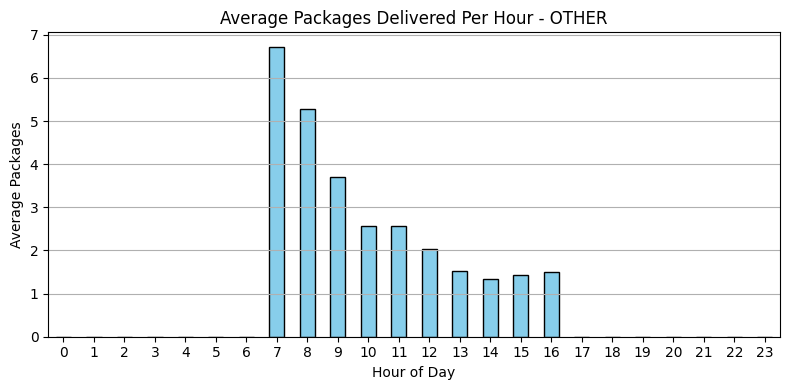

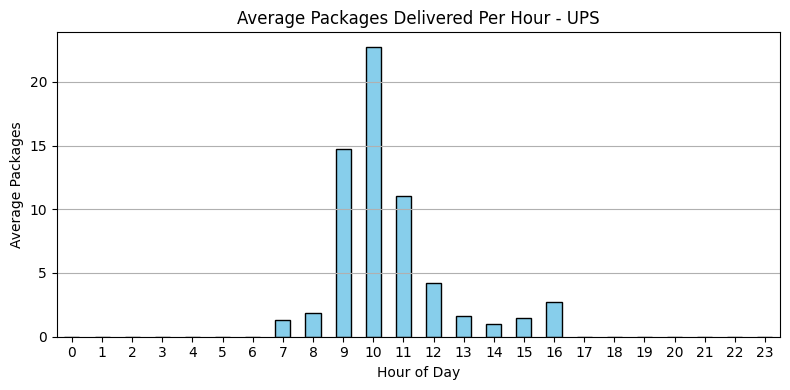

In [40]:
# Add a grouped carrier column including 'OTHER'
filtered_df["Carrier Grouped"] = filtered_df["Carrier Cleaned"].apply(
    lambda x: x if x in ["AMAZON", "USPS", "UPS", "FEDEX"] else "OTHER"
)

# Extract hour and date
filtered_df["Hour"] = filtered_df["Received Timestamp"].dt.hour
filtered_df["Date"] = filtered_df["Received Timestamp"].dt.date

# Group by Date, Hour, and Carrier Grouped
grouped_all = (
    filtered_df.groupby(["Date", "Hour", "Carrier Grouped"])
    .size()
    .reset_index(name="Package Count")
)

# Calculate average number of packages per hour across all days for each carrier group
avg_per_hour_grouped = (
    grouped_all.groupby(["Hour", "Carrier Grouped"])["Package Count"]
    .mean()
    .unstack(fill_value=0)
    .reindex(range(24), fill_value=0)
)

# Plot the full grouped histogram
plt.figure(figsize=(12, 6))
avg_per_hour_grouped.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Average Number of Packages Delivered Per Hour by Carrier (Grouped, Per Day)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Packages Delivered")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title="Carrier Group")
plt.tight_layout()
plt.show()

# Plot a smaller histogram for each individual carrier group
for carrier in avg_per_hour_grouped.columns:
    plt.figure(figsize=(8, 4))
    avg_per_hour_grouped[carrier].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Average Packages Delivered Per Hour - {carrier}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Packages")
    plt.xticks(rotation=0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

## 2. Input Modeling / Distributions

### 2.1 Simulating Arrivals

In [41]:
import numpy as np

# Step 1: Convert avg_per_hour_total into hourly Poisson λ values
lambda_by_hour = avg_per_hour_total.to_dict()

# Step 2: Simulate one day of package arrivals using piecewise time-dependent Poisson
simulated_arrivals = []

for hour in range(24):
    lam = lambda_by_hour.get(hour, 0)
    if lam > 0:
        # Draw number of arrivals from Poisson distribution
        arrivals_this_hour = np.random.poisson(lam)
        # Assign uniform random minutes within the hour for each arrival
        timestamps = pd.date_range(
            start=f"2023-09-04 {hour:02d}:00:00",
            periods=60, freq='T'
        )
        if arrivals_this_hour > 0:
            arrival_minutes = np.random.choice(timestamps, size=arrivals_this_hour, replace=True)
            simulated_arrivals.extend(arrival_minutes)

# Step 3: Convert to DataFrame
simulated_df = pd.DataFrame({
    "Simulated Arrival Timestamp": sorted(simulated_arrivals)
})

In [42]:
# Create the hourly Poisson rate table
lambda_table = pd.DataFrame({
    "Hour of Day": list(lambda_by_hour.keys()),
    "Poisson Rate λ (avg packages/hour)": [round(v, 2) for v in lambda_by_hour.values()]
})

In [43]:
# Assume raw 'Carrier' column exists; clean it and create USPS vs Non-USPS group
filtered_df["Carrier Cleaned"] = filtered_df["Carrier"].str.upper().str.strip()
filtered_df["Carrier USPS/Non-USPS"] = filtered_df["Carrier Cleaned"].apply(
    lambda x: "USPS" if x == "USPS" else "Non-USPS"
)

# Extract hour and date
filtered_df["Hour"] = filtered_df["Received Timestamp"].dt.hour
filtered_df["Date"] = filtered_df["Received Timestamp"].dt.date

# Exclude weekends
filtered_df = filtered_df[filtered_df["Received Timestamp"].dt.dayofweek < 5]

# Group by Date, Hour, and Carrier group
grouped_usps_non = (
    filtered_df.groupby(["Date", "Hour", "Carrier USPS/Non-USPS"])
    .size()
    .reset_index(name="Package Count")
)

# Compute average package count per hour per group
avg_per_hour_usps_non = (
    grouped_usps_non.groupby(["Hour", "Carrier USPS/Non-USPS"])["Package Count"]
    .mean()
    .unstack(fill_value=0)
    .reindex(range(24), fill_value=0)
)

# Display as a rate table
rate_table_usps_non = avg_per_hour_usps_non.reset_index().rename(columns={
    "USPS": "USPS λ",
    "Non-USPS": "Non-USPS λ"
})

## 3. Simulation

In [44]:
def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size) * (maximum - minimum) + minimum

In [45]:
# Constants
CLERK_SHIFT_HOURS = 8.5  
NUM_SIM_CLERKS = 8 # Change this depending on what configuration you want to test

# Simulation function
def run_clerk_with_delivery_simulation():
    global arrivals_df
    simulated_arrivals_all_days = []

    for day_offset in range(5):  # Monday to Friday
        date = pd.Timestamp("2023-09-04") + pd.Timedelta(days=day_offset)
        weekday = date.day_name()

        for hour in range(7, 17):  # 7AM to 5PM
            lam = lambda_by_hour.get(hour, 0)
            if lam > 0:
                arrivals_this_hour = np.random.poisson(lam)
                timestamps = pd.date_range(start=f"{date.date()} {hour:02d}:00:00", periods=60, freq='T')
                if arrivals_this_hour > 0:
                    arrival_minutes = np.random.choice(timestamps, size=arrivals_this_hour, replace=True)
                    for ts in arrival_minutes:
                        simulated_arrivals_all_days.append({
                            "Simulated Arrival Timestamp": ts,
                            "Day": weekday
                        })

    arrivals_df = pd.DataFrame(simulated_arrivals_all_days)

    if arrivals_df.empty:
        return {
            "Clerk Utilization": 0,
            "Packages": 0
        }

    # Assign sorting time (in minutes) using PERT(0.5, 1, 2)
    arrivals_df["Sorting Time (min)"] = sample_pert(0.5, 1, 2, size=len(arrivals_df))
    total_sorting_time = arrivals_df["Sorting Time (min)"].sum()

    # Use PERT distribution for delivery time: min=30, mode=50, max=75
    delivery_times = sample_pert(30, 50, 75, size=NUM_SIM_CLERKS * 4)  # 4 trips per clerk
    total_delivery_time = np.sum(delivery_times)

    # Customer service: 25 interactions per day, each 10–15 minutes
    customer_service_times = np.random.uniform(10, 15, size=25)
    total_service_time = np.sum(customer_service_times)

    # Dwight handles 90% of customer service unless out on a delivery
    dwight_delivery_time = sample_pert(30, 50, 75, size=4).sum()  # Dwight does 4 trips
    dwight_service_time = 0.9 * total_service_time

    # Estimate what fraction of Dwight’s time is unavailable (out on delivery)
    dwight_unavailable_fraction = dwight_delivery_time / (8.5 * 60)  # 8.5 hrs in minutes
    redistributed_service = dwight_service_time * dwight_unavailable_fraction
    total_service_time += redistributed_service

    # Define each clerk’s actual shift (start and end in hours)
    clerk_shifts = {
        "Dwight":     (7.0, 15.5),   # 7:00 AM to 3:30 PM
        "Robert":     (7.0, 15.5),
        "Marcia":     (7.0, 15.5),
        "Antonio":    (8.5, 17.0),   # 8:30 AM to 5:00 PM
        "Anthony":    (8.5, 17.0),
        "Hypo1":      (8.0, 16.5),   # Add or delete hypothetical clerks
        "Hypo2":      (8.0, 16.5),
        "Hypo3":      (8.0, 16.5)
    }

    # Calculate total available time based on actual shifts
    total_work_time = sum((end - start) * 60 for start, end in clerk_shifts.values())

    # Utilization
    total_utilization = (total_sorting_time + total_delivery_time + total_service_time) / total_work_time

    return {
        "Clerk Utilization": total_utilization,
        "Packages": len(arrivals_df),
    }

# Run simulation 1000 times
results_clerk_delivery = [run_clerk_with_delivery_simulation() for _ in range(1000)]
results_clerk_delivery_df = pd.DataFrame(results_clerk_delivery)

In [46]:
averages_only = results_clerk_delivery_df.mean().to_frame(name="Average Value").reset_index()
averages_only.rename(columns={"index": "Metric"}, inplace=True)
averages_only

,Metric,Average Value
0,Clerk Utilization,0.734553
1,Packages,872.083000


# 4. Sensitivity Analysis

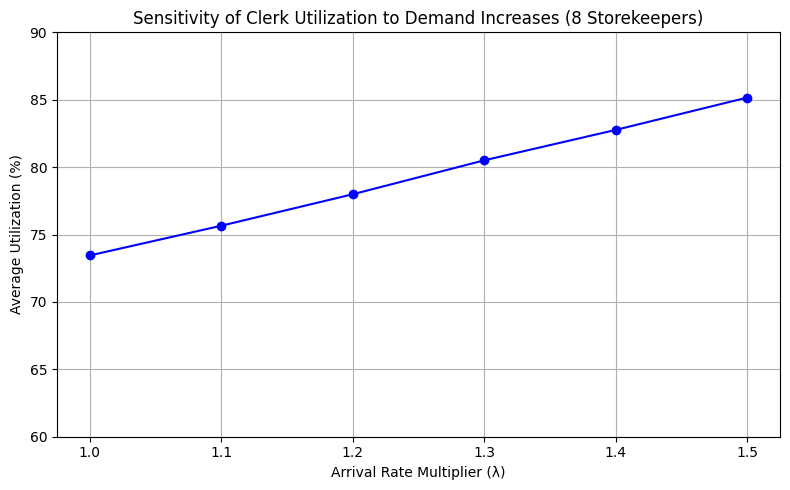

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta  = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size=size) * (maximum - minimum) + minimum

clerk_shifts = {
    "Dwight":     (7.0, 15.5),  # 7:00 AM – 3:30 PM
    "Robert":     (7.0, 15.5),
    "Marcia":     (7.0, 15.5),
    "Antonio":    (8.5, 17.0),  # 8:30 AM – 5:00 PM
    "Anthony":    (8.5, 17.0),
    "Hypo1":      (8.0, 16.5),  # 8:00 AM – 4:30 PM
    "Hypo2":      (8.0, 16.5),
    "Hypo3":      (8.0, 16.5)
}

NUM_SIM_CLERKS = len(clerk_shifts)

base_lambda_by_hour = avg_per_hour_total.to_dict()

def run_clerk_sim_with_scaled_lambda(scale_multiplier=1.0):
    lambda_by_hour = {hour: lam * scale_multiplier for hour, lam in base_lambda_by_hour.items()}
    simulated_arrivals_all_days = []

    for day_offset in range(5):  # Monday to Friday
        date = pd.Timestamp("2023-09-04") + pd.Timedelta(days=day_offset)
        weekday = date.day_name()

        for hour in range(7, 17):  # 7AM to 5PM
            lam = lambda_by_hour.get(hour, 0)
            if lam > 0:
                arrivals_this_hour = np.random.poisson(lam)
                timestamps = pd.date_range(start=f"{date.date()} {hour:02d}:00:00", periods=60, freq='T')
                if arrivals_this_hour > 0:
                    arrival_minutes = np.random.choice(timestamps, size=arrivals_this_hour, replace=True)
                    for ts in arrival_minutes:
                        simulated_arrivals_all_days.append({
                            "Simulated Arrival Timestamp": ts,
                            "Day": weekday
                        })

    arrivals_df = pd.DataFrame(simulated_arrivals_all_days)

    if arrivals_df.empty:
        return {
            "Clerk Utilization": 0,
            "Packages": 0
        }

    # Sorting time
    arrivals_df["Sorting Time (min)"] = sample_pert(0.5, 1, 2, size=len(arrivals_df))
    total_sorting_time = arrivals_df["Sorting Time (min)"].sum()

    # Delivery time: 4 trips per clerk
    delivery_times = sample_pert(30, 50, 75, size=NUM_SIM_CLERKS * 4)
    total_delivery_time = np.sum(delivery_times)

    # Customer service
    customer_service_times = np.random.uniform(10, 15, size=25)
    total_service_time = np.sum(customer_service_times)

    # Dwight handles 90% of customer service unless on delivery
    dwight_delivery_time = sample_pert(30, 50, 75, size=4).sum()
    dwight_service_time = 0.9 * total_service_time
    dwight_unavailable_fraction = dwight_delivery_time / (8.5 * 60)
    redistributed_service = dwight_service_time * dwight_unavailable_fraction
    total_service_time += redistributed_service

    # Total available time from all shifts
    total_work_time = sum((end - start) * 60 for start, end in clerk_shifts.values())

    total_utilization = (total_sorting_time + total_delivery_time + total_service_time) / total_work_time

    return {
        "Clerk Utilization": total_utilization,
        "Packages": len(arrivals_df)
    }

# Sensitivity analysis
multipliers = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
utilizations = []

for m in multipliers:
    sims = [run_clerk_sim_with_scaled_lambda(scale_multiplier=m) for _ in range(200)]
    avg_util = np.mean([s["Clerk Utilization"] for s in sims]) * 100
    utilizations.append(avg_util)

plt.figure(figsize=(8, 5))
plt.plot(multipliers, utilizations, marker='o', color='blue', label='Average Utilization')
plt.title("Sensitivity of Clerk Utilization to Demand Increases (8 Storekeepers)")
plt.xlabel("Arrival Rate Multiplier (λ)")
plt.ylabel("Average Utilization (%)")
plt.ylim(60, 90)
plt.grid(True)
plt.tight_layout()
plt.show()